In [99]:
import yfinance as yf
import requests
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from scipy.signal import argrelextrema
import matplotlib.colors as mcolors
import seaborn

In [64]:
def search_stock_symbol(company_name):
    url = f'https://www.alphavantage.co/query?function=SYMBOL_SEARCH&keywords={company_name}&apikey=Y9DN79N2PBBK2X1O'
    
    # Send request to Alpha Vantage API
    response = requests.get(url)
    data = response.json()
    
    # Extract and print best matches
    if 'bestMatches' in data:
        matches = data['bestMatches']
        for match in matches:
        
            if match['4. region'] == 'India/Bombay':
                symbol = match['1. symbol']
                name = match['2. name']

                return symbol,name

            else:
                continue
    
    else:
        
        raise ValueError("No such company found")

In [3]:
def symbol_changes(symbol):
    symbol = symbol[:-3]
    symbol += "NS"
    
    return symbol

In [14]:
def pe_and_market_cap(all_info):
    
    share_price = all_info['currentPrice']
    no_shares = all_info['sharesOutstanding']
    eps = all_info['trailingEps']
    
    market_cap = share_price * no_shares
    pe = market_cap/ (eps * no_shares)
    
    if market_cap < (5000 * (10 **7)):
        Id ='s' #Small Cap

    elif (5000 * (10 ** 7)) < market_cap < 20000 * (10 ** 7):
        Id ='m' #Middle Cap

    else:
           Id ='l' #Large Cap
    
    if Id == 'l':
        id2 = 1
        
    else:
        id2 = 0
    
    return market_cap, pe, id2

In [5]:
def macd(data):
    
    ma12 = data['Close'].ewm(span=12, adjust=False).mean()
    ma26 = data['Close'].ewm(span=26, adjust=False).mean()
    macd = ma12 - ma26
    sl = macd.ewm(span=9, adjust=False).mean()
    
    histo = macd - sl
    
    data["MACD"] = macd
    data['Signal Line'] = sl
    data['Histogram'] = histo
    
    data['Signal'] = np.where((data['MACD'] > data['Signal Line']) & 
                              (data['MACD'].shift(1) <= data['Signal Line'].shift(1)), 1, 0)
    
    data['Signal'] = np.where((data['MACD'] < data['Signal Line']) & 
                              (data['MACD'].shift(1) >= data['Signal Line'].shift(1)), -1, data['Signal'])
    
    # Creating a column for prediction (Buy or Sell)
    data['Prediction'] = data['Signal'].apply(lambda x: 'Buy' if x == 1 else ('Sell' if x == -1 else 'Hold'))
    
    return data[['Close', 'MACD', 'Signal Line', 'Histogram', 'Prediction']]

In [6]:
def rsi(data, window=14):
    delta = data['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    # Calculate initial average gains and losses
    avg_gain = gain[:window].mean()
    avg_loss = loss[:window].mean()
    
    # Initialize RSI values
    rsi_values = []
    
    # Iterate through the rest of the data
    for i in range(window, len(data)):
        avg_gain = (avg_gain * (window - 1) + gain.iloc[i]) / window
        avg_loss = (avg_loss * (window - 1) + loss.iloc[i]) / window
        
        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        
        rsi_values.append(rsi)
    
    # Add RSI column to the DataFrame
    data['RSI'] = pd.Series(rsi_values, index=data.index[window:])
    
    return data[window:]

In [7]:
# # Not giving the right answer
# def lifetime_high(company_name):
    
#     symbol = inp(company_name)
#     comp = yf.Ticker(symbol)
#     data = comp.history(period='1y', interval='1d')
    
#     return round(data['High'].max(), 3)

In [35]:
def fibonacci_retracement(data, window_size=10, threshold=0.03):
    close_prices = data['Close'].values
    
    # Function to identify trends
    def identify_trend(prices, window):
        trends = np.zeros(len(prices))
        for i in range(window, len(prices)):
            if prices[i] > prices[i-window]:
                trends[i] = 1  # Uptrend
            elif prices[i] < prices[i-window]:
                trends[i] = -1  # Downtrend
        return trends
    
    # Identify trends
    trends = identify_trend(close_prices, window_size)
    
    # Find the most recent significant trend change
    trend_changes = np.diff(trends)
    significant_changes = np.where(np.abs(trend_changes) > 0)[0]
    
    if len(significant_changes) > 0:
        last_change = significant_changes[-1]
        current_trend = "uptrend" if trends[last_change + 1] == 1 else "downtrend"
        
        # Find high and low prices since the trend change
        if current_trend == "uptrend":
            low_price = np.min(close_prices[max(0, last_change-window_size):last_change+1])
            high_price = np.max(close_prices[last_change+1:])
        else:
            high_price = np.max(close_prices[max(0, last_change-window_size):last_change+1])
            low_price = np.min(close_prices[last_change+1:])
    else:
        # If no significant trend change, use the entire dataset
        current_trend = "uptrend" if close_prices[-1] > close_prices[0] else "downtrend"
        high_price = np.max(close_prices)
        low_price = np.min(close_prices)
    
    # Ensure we have valid high and low prices
    if high_price == low_price:
        high_price = np.max(close_prices)
        low_price = np.min(close_prices)
        current_trend = "uptrend" if close_prices[-1] > close_prices[0] else "downtrend"
    
    # Calculate Fibonacci levels
    diff = high_price - low_price
    retracement_levels = {
        "23.6%": high_price - 0.236 * diff if current_trend == "uptrend" else low_price + 0.236 * diff,
        "38.2%": high_price - 0.382 * diff if current_trend == "uptrend" else low_price + 0.382 * diff,
        "50%": high_price - 0.500 * diff if current_trend == "uptrend" else low_price + 0.500 * diff,
        "61.8%": high_price - 0.618 * diff if current_trend == "uptrend" else low_price + 0.618 * diff,
        "78.6%": high_price - 0.786 * diff if current_trend == "uptrend" else low_price + 0.786 * diff
    }
    
    extension_levels = {
        "123.6%": high_price + 0.236 * diff,
        "138.2%": high_price + 0.382 * diff,
        "150%": high_price + 0.500 * diff,
        "161.8%": high_price + 0.618 * diff,
        "200%": high_price + diff,
    }
    
    return {
        "trend": current_trend,
        "prices": {
            "high_price": high_price,
            "low_price": low_price
        },
        "retracement_levels": retracement_levels,
        "extension_levels": extension_levels,
    }

In [36]:
symbol = search_stock_symbol('hindustan copper')
symbol = symbol_changes(symbol)
comp = yf.Ticker(symbol)
data = comp.history(period='1y', interval='1d')

In [37]:
d = fibonacci_retracement(data)

In [38]:
d

{'trend': 'uptrend',
 'prices': {'high_price': 341.8500061035156, 'low_price': 306.1180725097656},
 'retracement_levels': {'23.6%': 333.41726977539065,
  '38.2%': 328.2004074707031,
  '50%': 323.9840393066406,
  '61.8%': 319.76767114257814,
  '78.6%': 313.7647062988281},
 'extension_levels': {'123.6%': 350.2827424316406,
  '138.2%': 355.49960473632814,
  '150%': 359.7159729003906,
  '161.8%': 363.9323410644531,
  '200%': 377.5819396972656}}

In [9]:
def fib_insight(current_price, levels, trend):
    insights = []
    weight = 0

    if trend == 'uptrend':
        insights.append("Trend: Uptrend")
        for level_name, level_value in levels['extension'].items():
            if current_price <= level_value * 1.01 and current_price >= level_value * 0.99:  # Price is 1% away from the level
                insights.append(f"The current price is near the {level_name} extension level ({round(level_value, 2)}), indicating potential resistance. Hence SELL")
                weight -= 1  # Resistance

            # Further weight adjustments needs to be added here based on how far the price is from the level
            
            elif current_price > level_value:  # Price above the level
                weight += 1  # Strengthening bullish sentiment

    elif trend == 'downtrend':
        insights.append("Trend: Downtrend")
        for level_name, level_value in levels['retracement'].items():
            if current_price <= level_value * 1.01 and current_price >= level_value * 0.99:  # Price is 1% away from the level
                insights.append(f"The current price is near the {level_name} retracement level ({round(level_value, 2)}), indicating potential support. Hence BUY")
                weight += 1  # Support

            # Further weight adjustments needs to be added here based on how far the price is from the level
            
            elif current_price < level_value:  # Price below the level
                weight -= 1  # Weakening bullish sentiment

    return insights, weight

In [130]:
def visualise_fib(d, data):
    high = d["prices"]['high_price']
    low = d["prices"]['low_price']
    trend = d["trend"]
    
    retracement_levels = d['retracement_levels']
    extension_levels = d['extension_levels']
    
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(data['Close'], label='Close Price', linewidth=3)
    plt.style.use('classic')
    
    trend_start_date = data.index[data['Close'] == low][0]
    trend_end_date = data.index[data['Close'] == high][0]
    
    ax.axvspan(trend_start_date, trend_end_date, color='yellow', alpha=0.3, label='Trend')
    
    # Sort levels as specified
    sorted_retracement = sorted(retracement_levels.items(), key=lambda x: float(x[0].strip('%')))
    sorted_extension = sorted(extension_levels.items(), key=lambda x: float(x[0].strip('%')), reverse=True)
    sorted_levels = sorted_extension + sorted_retracement
    
    extension_colors = ['#FF4136', '#FF851B', '#FFDC00', '#2ECC40', '#0074D9']  # Red, Orange, Yellow, Green, Blue
    retracement_colors = ['#B10DC9', '#F012BE', '#85144b', '#001f3f', '#39CCCC']  # Purple, Pink, Maroon, Navy, Teal
    
    # Combine colors
    colors = extension_colors[:len(extension_levels)] + retracement_colors[:len(retracement_levels)]
    
    for i, (label, level) in enumerate(sorted_levels):
        color = colors[i]
        linestyle = '--' if label in retracement_levels else ':'
        ax.axhline(level, linestyle=linestyle, color=color, linewidth=2)
        ax.plot(data.index[-1], level, 'o', color=color, markersize=6)
    
    ax.set_title('Fibonacci Retracement and Extension Levels', fontsize=16, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Price', fontsize=12)
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    
    extra_days = pd.Timedelta(days=20)
    ax.set_xlim(data.index[-180], data.index[-1]+extra_days)
    
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    # Create a second axes for the labels
    ax2 = ax.twinx()
    ax2.set_ylim(ax.get_ylim())
    ax2.set_yticks([])
    
    label_positions = np.linspace(0.95, 0.05, len(sorted_levels))
    for i, (label, level) in enumerate(sorted_levels):
        color = colors[i]
        ax2.text(1.02, label_positions[i], f'{label} ({round(level, 2)})', 
                 color=color, va='center', ha='left', fontweight='bold',
                 bbox=dict(facecolor='white', edgecolor=color, alpha=1, boxstyle='round,pad=0.3'),
                 transform=ax2.transAxes)
    
    plt.tight_layout()
    plt.show()
    
#     print("Fibonacci Levels:")
#     for label, level in sorted_levels:
#         print(f"{label} level: {round(level, 2)}")

In [126]:
def visualise_macd(data):
    
    # Ensure we're only using valid data points
    valid_data = data.dropna(subset=['MACD', 'Signal Line'])
    
    fig, ax1 = plt.subplots(1, figsize=(12,8))
    
    # Use a built-in style that's similar to Seaborn
    plt.style.use('ggplot')
    
    # Change colors to more pleasing options
    macd_color = '#1e90ff'  # Dodger Blue
    signal_color = '#ff6347'  # Tomato
    
    # Plot MACD and Signal lines
    ax1.plot(valid_data.index, valid_data['MACD'], label='MACD', color=macd_color, linewidth=1.5)
    ax1.plot(valid_data.index, valid_data['Signal Line'], label='Signal Line', color=signal_color, linestyle='--', linewidth=1.5)
    
    # Improve histogram appearance using fill_between instead of bar
    histogram = valid_data['MACD'] - valid_data['Signal Line']
    ax1.fill_between(valid_data.index, histogram, 0, where=histogram >= 0, facecolor='#2ecc71', alpha=0.7, interpolate=True, label='Positive Histogram')
    ax1.fill_between(valid_data.index, histogram, 0, where=histogram < 0, facecolor='#e74c3c', alpha=0.7, interpolate=True, label='Negative Histogram')
    
    # Enhance the legend
    ax1.legend(loc='upper left', frameon=True, fancybox=True, shadow=True)
    
    # Improve x-axis
    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    plt.xticks(rotation=45, ha='right')
    
    # Set title and labels
    ax1.set_title("MACD Indicator", fontsize=16, fontweight='bold')
    ax1.set_xlabel("Date", fontsize=12)
    ax1.set_ylabel("MACD Value", fontsize=12)
    
    
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Adjust layout
    plt.tight_layout()
    
    plt.show()

In [12]:
def visualise_rsi(data):
    
    fig, ax2 = plt.subplots(1, figsize=(12,8))
    ax2.plot(data.index, data['RSI'], label='RSI', color='green', linewidth=1.5)
    ax2.axhline(70, linestyle='--', alpha=0.5, color='red')  # Overbought threshold
    ax2.axhline(30, linestyle='--', alpha=0.5, color='blue')  # Oversold threshold
    ax2.legend(loc='upper left')
    
    ax2.xaxis.set_major_locator(mdates.MonthLocator())
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax2.set_title("RSI")

Enter a name: tata steel

Buy stocks of Tata Steel Limited
Current Price of Tata Steel Limited: 165.61
Market Cap of Tata Steel Limited: 206739.24 Crores
The P/E ratio is -49.29, which is below 20, hence BUY


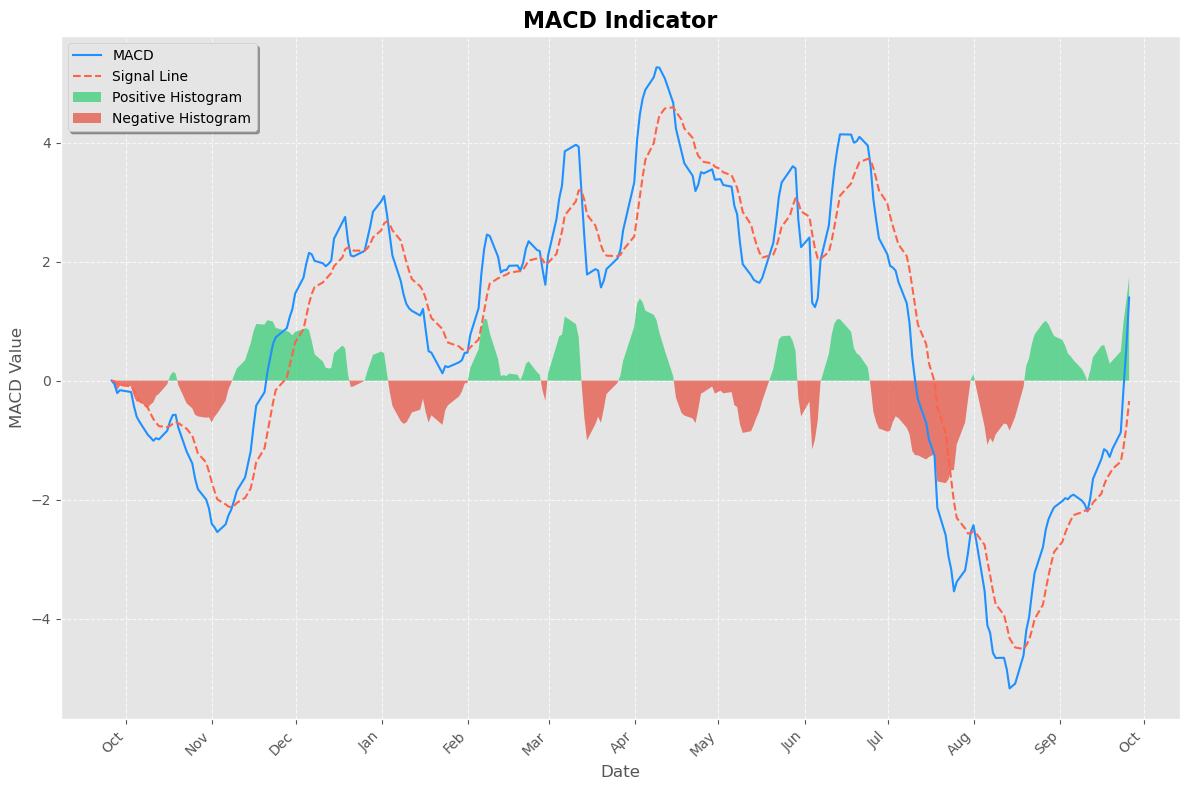

MACD and signal are above 0, hence HOLD/SELL
RSI value is 70.342, suggesting it is overbought, hence SELL


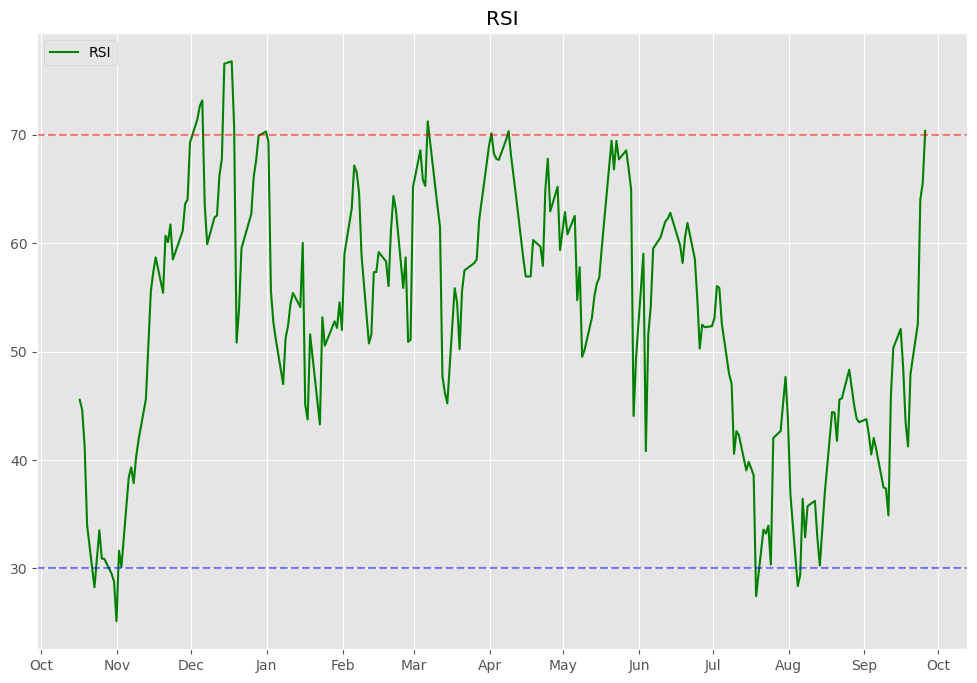

In [128]:
#INPUT
name = input('Enter a name: ')

# PREPROCESSING THE NAME
symbol,st_name = search_stock_symbol(name)
symbol = symbol_changes(symbol)

# API CALL
comp = yf.Ticker(symbol)
data = comp.history(period='1y', interval='1d')
info = comp.info

curr_price = info['currentPrice']

weights = {
    'pe': 0.4,
    'rsi': 0.3,
    'macd': 0.3,
    'fib': 0.3
}

# PE RATIO AND CAP ID
info = pe_and_market_cap(info)

if info[2] != 1:
    print('The company is not large cap')
    
else:
    pe = info[1]
    
    if pe <= 20:
        pe_score = 1  # Buy
        pe_response = f'The P/E ratio is {round(pe,2)}, which is below 20, hence BUY'
    
    else:
        pe_score = -1  # Sell
        pe_response = f'The P/E ratio is {round(pe,2)}, which is above 20, hence SELL'
        
        
    # RSI
    r = rsi(data)
    rsi_value = r['RSI']
    
    
    if 70 > rsi_value.iloc[-1] > 50:
        rsi_score = -0.5  # Mild Sell
        rsi_response = f'RSI value is {round(rsi_value.iloc[-1],3)}, suggesting the stock is inclining to be over-bought, hence HOLD'
    
    elif 50 > rsi_value.iloc[-1] > 30:
        rsi_score = 0.5  # Mild Buy
        rsi_response = f'RSI value is {round(rsi_value.iloc[-1],3)}, suggesting the stock is inclining to be under-bought, hence HOLD'
    
    elif rsi_value.iloc[-1] > 70:
        rsi_score = -1  # Strong Sell
        rsi_response = f'RSI value is {round(rsi_value.iloc[-1],3)}, suggesting it is overbought, hence SELL'
    
    elif rsi_value.iloc[-1] < 30:
        rsi_score = 1  # Strong Buy
        rsi_response = f'RSI value is {round(rsi_value.iloc[-1],3)}, suggesting it is oversold, hence BUY'
    
    # MACD
    ma = macd(data)
    result = ma[-1:]
    
    pred = ma['Prediction']
    
    if pred.iloc[-1] == 'Buy':
        macd_score = 1  # Buy
        macd_response = f'The MACD line is cutting from above, hence BUY'
        
    elif pred.iloc[-1] == 'Sell':
        macd_score = -1  # Sell
        macd_response = f'The MACD line is cutting from below, hence SELL'
        
    else:
        val = ma['Histogram']
        
        if val.iloc[-1] < 0:
            macd_score = 0  # Hold
            macd_response = f"MACD and signal are below 0, hence HOLD/BUY"
            
        else:
            macd_score = 0  # Hold
            macd_response = f"MACD and signal are above 0, hence HOLD/SELL"
                   
        
    # Fibonacci Retracement
    fib = fibonacci_retracement(data)
    
    current_price = data['Close'].iloc[-1]
    trend = fib['trend']
    
    levels = dict()
    levels['retracement'] = fib['retracement_levels']
    levels ['extension'] = fib['extension_levels'] 
    
    
    fib_response, fib_score = fib_insight(current_price=current_price, trend=trend, levels=levels)
            

final_score = (pe_score * weights['pe']) + (rsi_score * weights['rsi']) + (macd_score * weights['macd']) + (fib_score * weights['fib'])

# Decision based on final score
if final_score > 0:
    print(f'\nBuy stocks of {st_name}')
else:
    print(f'\nSell your stocks of {st_name}')
    

print(f'Current Price of {st_name}: {curr_price}')
print(f'Market Cap of {st_name}: {round(info[0] / (10 ** 7) , 2)} Crores')

print(pe_response)  

visualise_macd(ma)
print(macd_response)

visualise_rsi(r)
print(rsi_response)

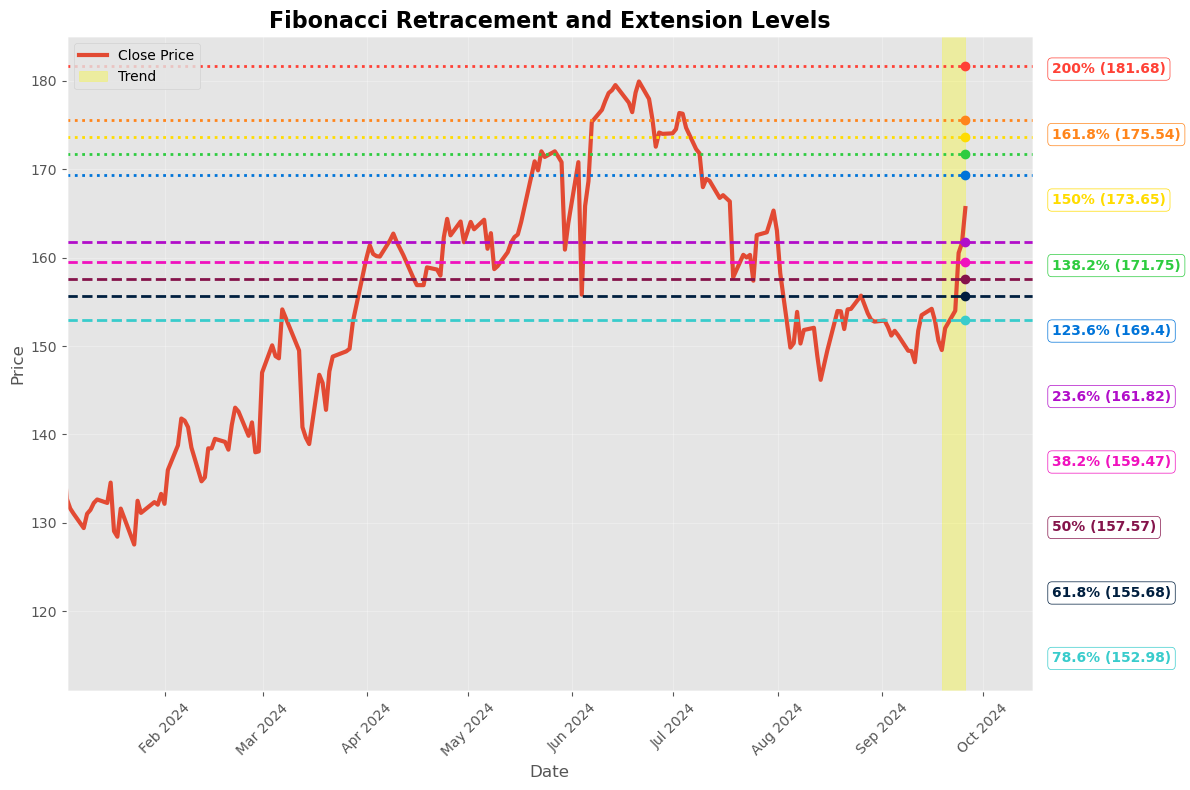

Trend: Uptrend


IndexError: list index out of range

In [129]:
visualise_fib(fib, data)
print(fib_response[0])
print(fib_response[1])